In [1]:
import my_utils as mu
import torch
from torch import nn
from IPython import display
import torch.nn.functional as F

In [2]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

In [3]:
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        #STEM
        self.Linear1 = nn.Linear(16, 128)

        #Backbone
        self.Linear2 = nn.Linear(49, 128)
        self.Linear3 = nn.Linear(128, 49)
        self.Linear4 = nn.Linear(128, 49)
        self.Linear5 = nn.Linear(49, num_outputs)

        torch.nn.init.normal_(self.Linear1.weight, std=0.01) #initializing the weights to normal distributions
        torch.nn.init.zeros_(self.Linear1.bias) #initializing the bias to 0
      
        torch.nn.init.normal_(self.Linear2.weight, std=0.01) #initializing the weights to normal distributions
        torch.nn.init.zeros_(self.Linear2.bias) #initializing the bias to 0

        torch.nn.init.normal_(self.Linear3.weight, std=0.01) #initializing the weights to normal distributions
        torch.nn.init.zeros_(self.Linear3.bias) #initializing the bias to 0

        torch.nn.init.normal_(self.Linear4.weight, std=0.01) #initializing the weights to normal distributions
        torch.nn.init.zeros_(self.Linear4.bias) #initializing the bias to 0

        torch.nn.init.normal_(self.Linear5.weight, std=0.01) #initializing the weights to normal distributions
        torch.nn.init.zeros_(self.Linear5.bias) #initializing the bias to 0
        
        
    def forward(self, A):
       
        Al = F.unfold(A,4,stride=4)
        A1 = torch.transpose(Al,1,2)
        A_in = self.Linear1(A1)
 
        A2 = torch.transpose(A_in,1,2)

        A3 = F.relu(self.Linear2(A2))
        A4 = self.Linear3(A3)
       
        A5 = torch.transpose(A4,1,2)
        A6 = F.relu(self.Linear4(A5))
        A7 = self.Linear5(A6)

        A_out = torch.mean(A7,1)
        return A_out

num_inputs, num_outputs = 128, 10
net = Net(num_inputs, num_outputs)

In [5]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

class Accumulator:  
    """For accumulat§ ing sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # correct predictions number , predictions number
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    print(metric[0] / metric[1])

    return metric[0] / metric[1]

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

In [6]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Computing the gradients and updating the parameters   
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        break
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [7]:
class Animator: 
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [8]:
from tqdm import tqdm
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):  
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    evaluate_accuracy(net, test_iter)
    train_loss, train_acc = train_metrics
    assert train_loss < 0.6, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

0.8028


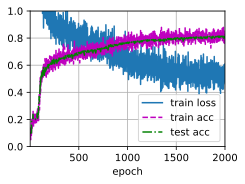

In [10]:
num_epochs = 2000
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)